# Evaluate CCLM soil temperature with ERA5 and ERA5-Land

In [1]:
from pathlib import Path

import xarray as xr
import pandas as pd

import valenspy as vp #The Valenspy package
from valenspy.input.converter_functions import ERA5_to_CF, CCLM_to_CF
from valenspy._utilities import load_xarray_from_data_sources
from yaml import safe_load
from valenspy.processing.select import convert_geo_to_rot
import numpy as np
import matplotlib.pyplot as plt


In [18]:
machine = "hortense"
variable = "tsl"
ref_dataset = "ERA5"


experiments = ["EUR11_NU_TT_EC_TSO", "EUR11_NU_TT_EC_TSO_soil", "EUR11_1994_NU_TT_EC_TSO", "EUR11_1993_NU_TT_EC_TSO"]

experiment = "EUR11_NU_TT_EC_TSO"

# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'bertrix'    : (5.25, 49.854),
}
point_id = 'opwijk'
point_coord = d_point_coords[point_id]


months_to_analyse = [6,7,8]


In [19]:
# ERA5 files (manually loaded and converted)
obs_files = ['/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_1/hourly/era5-hourly-europe-soil_temperature_level_1-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_2/hourly/era5-hourly-europe-soil_temperature_level_2-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_3/hourly/era5-hourly-europe-soil_temperature_level_3-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/hourly/era5-hourly-europe-soil_temperature_level_4-1995.nc']




In [20]:
def plot_point_soiltemperature(ref_dataset, obs_files, variable, experiments, point_coord, point_id,  months_to_analyse, ax=False): 


    # 1. manually load ERA5

    ds = load_xarray_from_data_sources(obs_files)

    # rename dimensions if not yet renamed
    if "lon" not in ds.coords:
        ds = ds.rename({"longitude": "lon"})
    if "lat" not in ds.coords:
        ds = ds.rename({"latitude": "lat"})

    # make sure lat and lon are sorted ascending
    ds = ds.sortby('lat').sortby('lon')

    # bugfix ERA5 (found in clh): replace valid_time by time
    if "time" not in ds: 
        ds = ds.rename({'valid_time':'time'})

    ds = ds.resample(time='1D').mean()  


    # hardcoded from https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings 

    era5_soillayers = {'soil_depth': [0.07,0.28,1,2.89], 'thickness': [0.07,0.21,0.72,1.89], 
    'layer': ['0 - 7 cm','7 - 28 cm', '28 - 100 cm ', '100 - 289 cm']} #m 

    da_obs= xr.concat([ds['stl1'], ds['stl2'], ds['stl3'], ds['stl4']], dim='soil_depth')

    da_obs['soil_depth'] = era5_soillayers['soil_depth']

    ds_obs = da_obs.to_dataset(name=variable)

    # select point from obs

    ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
    da_obs_point_timmean = da_obs_point.mean('time')

    # 2. Load CCLM experiments

    src_path = Path("../src/valenspy")

    # define postprocessing base directory of CCLM
    postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

    # get experiment name

    # get the file directory based on the model name. 

    # reference dataset to compare to
    model_name = 'CCLM'

    # get lookup file for model
    with open(src_path / "ancilliary_data" / Path(model_name+"_lookup.yml")) as file:
        mod_LOOKUP = safe_load(file)



    # get CCLM variable corresponding to the requested variable using its look-up table
    mod_var = mod_LOOKUP[variable]['raw_name']


    d_da_mod_point = {}
    for experiment in experiments: 

        # define the path
        directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/daily/')

        # define the CCLM files for the corresponding variable
        cclm_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

        #Import Converter - This input converter will not do anything to the data.
        ic = vp.InputConverter(CCLM_to_CF)
        ds_mod = ic.convert_input(cclm_files) # Convert the input to the correct format

        ds_mod = ds_mod.rename({'soil1':'soil_depth'})

        coord_points_rotated = convert_geo_to_rot(point_coord, ds_mod)
        ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

        da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        da_mod_point_timmean = da_mod_point.mean('time')

        d_da_mod_point[experiment] = da_mod_point_timmean



    if not ax: 
        fig, ax = plt.subplots(figsize = (7,3))

    ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
    for experiment in experiments: 
        ax.plot(d_da_mod_point[experiment].values, d_da_mod_point[experiment]['soil_depth'].values,  label=experiment)

    ax.invert_yaxis()
    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
    #ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
    ax.set_ylabel('Soil depth (m)')
    ax.set_ylim([12,-0.5])
    
    ax.axhlines(da_mod_point_timmean.soil_depth.values, color="gray", linewidth = 0.5)

    return ax



In [21]:
def plot_timeseries_twopoints(variable, ref_dataset, obs_files, experiments, d_point_coords,  months_to_analyse):

    "Wrapper function to combine 4 point timeseries plot into one figure, with nice layout (legend and title)"
    fig, axes = plt.subplots(1,2,figsize = (6,5))
    axes = axes.flatten()

    for i,point_id in enumerate(d_point_coords): 
        ax = axes[i]
        ax = plot_point_soiltemperature(ref_dataset, obs_files, variable, experiments, d_point_coords[point_id], point_id,  months_to_analyse, ax=ax)
        if i ==1: 
            ax.legend(frameon=False, loc='lower right')

    fig.tight_layout()

Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


OSError: no files to open

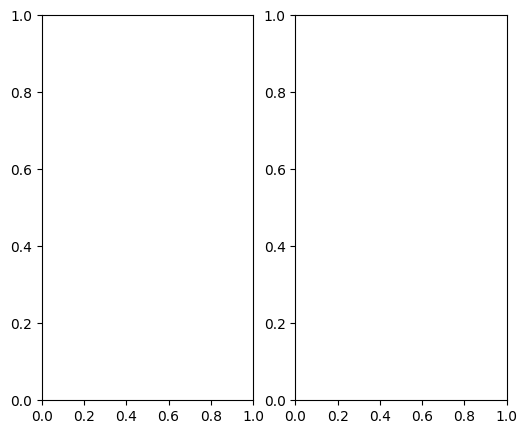

In [22]:
plot_timeseries_twopoints(variable, ref_dataset, obs_files, experiments, d_point_coords,  months_to_analyse)

## raw code

In [ ]:
experiments = ["EUR11_CO_TT_EC_TSO", "EUR11_NU_TT_EC_soil","EUR11_1994_NU_TT_EC_TSO", "EUR11_1993_NU_TT_EC_TSO", ]


In [ ]:
from valenspy._utilities import load_yml
# 1. manually load ERA5

ds = load_xarray_from_data_sources(obs_files)

# rename dimensions if not yet renamed
if "lon" not in ds.coords:
    ds = ds.rename({"longitude": "lon"})
if "lat" not in ds.coords:
    ds = ds.rename({"latitude": "lat"})

# make sure lat and lon are sorted ascending
ds = ds.sortby('lat').sortby('lon')

# bugfix ERA5 (found in clh): replace valid_time by time
if "time" not in ds: 
    ds = ds.rename({'valid_time':'time'})

ds = ds.resample(time='1D').mean()  


# hardcoded from https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings 

era5_soillayers = {'soil_depth': [0.07,0.28,1,2.89], 'thickness': [0.07,0.21,0.72,1.89], 
'layer': ['0 - 7 cm','7 - 28 cm', '28 - 100 cm ', '100 - 289 cm']} #m 

da_obs= xr.concat([ds['stl1'], ds['stl2'], ds['stl3'], ds['stl4']], dim='soil_depth')

da_obs['soil_depth'] = era5_soillayers['soil_depth']

ds_obs = da_obs.to_dataset(name=variable)

# select point from obs

ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin([5,6,7,8]))



# 2. Load CCLM experiments

# define postprocessing base directory of CCLM
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

# get experiment name

# get the file directory based on the model name. 

# reference dataset to compare to
model_name = 'CCLM'

# get lookup file for model
mod_LOOKUP = load_yml(model_name+"_lookup")

# get CCLM variable corresponding to the requested variable using its look-up table
mod_var = mod_LOOKUP[variable]['raw_name']

d_da_mod_point = {}
d_ds_mod = {}

for experiment in experiments: 

    # define the path
    directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/daily/')

    # define the CCLM files for the corresponding variable
    cclm_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

    #Import Converter - This input converter will not do anything to the data.
    ic = vp.InputConverter(CCLM_to_CF)
    ds_mod = ic.convert_input(cclm_files) # Convert the input to the correct format

    ds_mod = ds_mod.rename({'soil1':'soil_depth'})
    d_ds_mod[experiment] = ds_mod
    coord_points_rotated = convert_geo_to_rot(point_coord, ds_mod)
    ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

    da_mod_point = ds_mod_point[variable]

    d_da_mod_point[experiment] = da_mod_point


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


In [ ]:
d_da_mod_point

NameError: name 'd_da_mod_point' is not defined

In [ ]:
fig, ax = plt.subplots(figsize = (3,6))

da_obs_point_timmean = da_obs_point.sel(time='1995-05-01')


ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
for experiment in experiments: 

    da_mod_time = d_da_mod_point[experiment].sel(time='1995-05-01').squeeze()
    ax.plot(da_mod_time.values, da_mod_time['soil_depth'].values,  label=experiment)

ax.invert_yaxis()
ax.set_title(' ', loc='center')
ax.set_title('1-5-1995', loc='left')

#ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
ax.set_ylabel('Soil depth (m)')
ax.set_ylim([12,-0.5])
ax.set_xlabel('Soil temperature (K)')
ax.legend(frameon=False, loc='lower right')


for soil_depth in da_mod_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="gray", linewidth = 0.5, label='CCLM soil levels')
    
for soil_depth in da_obs_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="red", linewidth = 0.5, linestyle='-')



NameError: name 'plt' is not defined

In [ ]:
fig, ax = plt.subplots(figsize = (3,6))



da_obs_point_timmean = da_obs_point.sel(time='1995-08-31')


ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
for experiment in experiments: 

    da_mod_time = d_da_mod_point[experiment].sel(time='1995-08-31').squeeze()
    ax.plot(da_mod_time.values, da_mod_time['soil_depth'].values,  label=experiment)

ax.invert_yaxis()
ax.set_title(' ', loc='center')
ax.set_title('31-08-1995', loc='left')

#ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
ax.set_ylabel('Soil depth (m)')
ax.set_ylim([12,-0.5])
ax.set_xlabel('Soil temperature (K)')

ax.legend(frameon=False, loc='lower right')


for soil_depth in da_mod_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="gray", linewidth = 0.5, label='CCLM soil levels')
    
for soil_depth in da_obs_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="red", linewidth = 0.5, linestyle='-')



NameError: name 'plt' is not defined

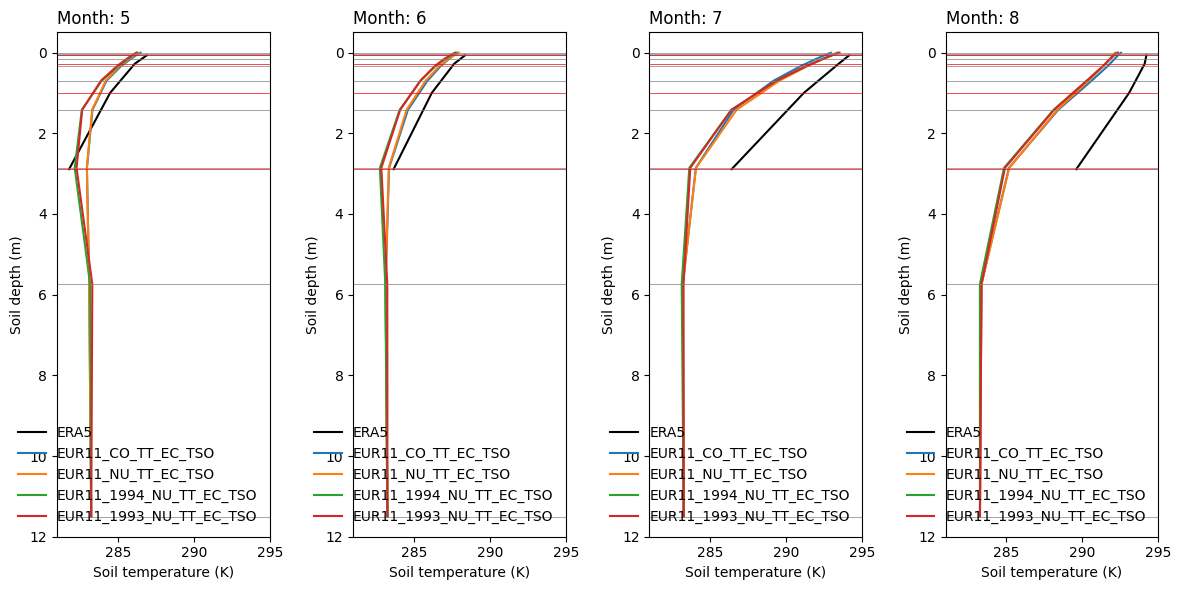

In [ ]:
fig, axes = plt.subplots(1,4,figsize = (12,6))
axes = axes.flatten()

for i,month in enumerate([5,6,7,8]): 
    ax= axes[i]



    da_obs_point_timmean = da_obs_point.sel(time=da_obs_point['time'].dt.month.isin(month)).mean('time')


    ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
    for experiment in experiments: 

        da_mod_time = d_da_mod_point[experiment].sel(time=d_da_mod_point[experiment]['time'].dt.month.isin(month))
        
        da_mod_time = da_mod_time.sel(time=da_mod_time['time'].dt.year.isin(1995)).mean('time').squeeze()
        ax.plot(da_mod_time.values, da_mod_time['soil_depth'].values,  label=experiment)

    ax.invert_yaxis()
    ax.set_title(' ', loc='center')
    ax.set_title('Month: '+str(month), loc='left')

    #ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
    ax.set_ylabel('Soil depth (m)')
    ax.set_ylim([12,-0.5])
    ax.set_xlim([281,295])

    ax.set_xlabel('Soil temperature (K)')

    ax.legend(frameon=False, loc='lower right')


    for soil_depth in da_mod_point_timmean.soil_depth.values: 
        ax.axhline(soil_depth, color="gray", linewidth = 0.5, label='CCLM soil levels')
        
    for soil_depth in da_obs_point_timmean.soil_depth.values: 
        ax.axhline(soil_depth, color="red", linewidth = 0.5, linestyle='-')

fig.tight_layout()


In [53]:
 d_da_mod_point[experiment]

<xarray.DataArray 'tsl' (soil_depth: 10)> Size: 40B
dask.array<mean_agg-aggregate, shape=(10,), dtype=float32, chunksize=(6,), chunktype=numpy.ndarray>
Coordinates:
    lon         float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lat         float32 4B dask.array<chunksize=(), meta=np.ndarray>
    rlon        float32 4B -8.685
    rlat        float32 4B 1.045
  * soil_depth  (soil_depth) float32 40B 0.005 0.025 0.07 ... 2.86 5.74 11.5
Attributes:
    standard_name:       soil_temperature
    long_name:           Temperature of Soil
    units:               K
    grid_mapping:        rotated_pole
    cell_methods:        time: point
    original_name:       T_SO
    original_long_name:  soil temperature
    original_units:      K
    experiment:          
    dataset:             CCLM
    freq:                daily

KeyError: 'time'

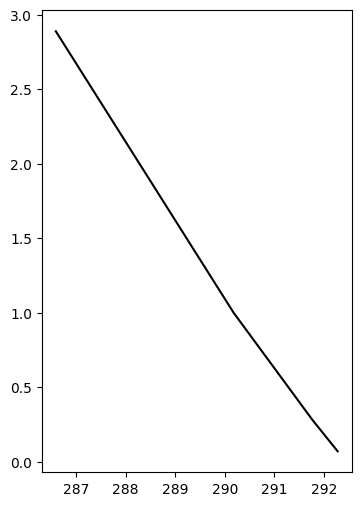

In [58]:
fig, ax = plt.subplots(figsize = (4,6))


da_obs_point_timmean = da_obs_point.sel(time=da_obs_point['time'].dt.month.isin(months_to_analyse)).mean('time')


ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
for experiment in experiments: 

    da_mod_time = d_da_mod_point[experiment].sel(time=d_da_mod_point[experiment]['time'].dt.month.isin(month))
    
    da_mod_time = da_mod_time.sel(time=da_mod_time['time'].dt.year.isin(1995)).mean('time').squeeze()
    ax.plot(da_mod_time.values, da_mod_time['soil_depth'].values,  label=experiment)

ax.invert_yaxis()
ax.set_title(' ', loc='center')
ax.set_title('Month: '+str(month), loc='left')

#ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
ax.set_ylabel('Soil depth (m)')
ax.set_ylim([12,-0.5])
ax.set_xlim([281,295])

ax.set_xlabel('Soil temperature (K)')

ax.legend(frameon=False, loc='lower right')


for soil_depth in da_mod_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="gray", linewidth = 0.5, label='CCLM soil levels')
    
for soil_depth in da_obs_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="red", linewidth = 0.5, linestyle='-')

fig.tight_layout()


#### time average profile

In [56]:
from valenspy._utilities import load_yml
# 1. manually load ERA5

ds = load_xarray_from_data_sources(obs_files)

# rename dimensions if not yet renamed
if "lon" not in ds.coords:
    ds = ds.rename({"longitude": "lon"})
if "lat" not in ds.coords:
    ds = ds.rename({"latitude": "lat"})

# make sure lat and lon are sorted ascending
ds = ds.sortby('lat').sortby('lon')

# bugfix ERA5 (found in clh): replace valid_time by time
if "time" not in ds: 
    ds = ds.rename({'valid_time':'time'})

ds = ds.resample(time='1D').mean()  


# hardcoded from https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings 

era5_soillayers = {'soil_depth': [0.07,0.28,1,2.89], 'thickness': [0.07,0.21,0.72,1.89], 
'layer': ['0 - 7 cm','7 - 28 cm', '28 - 100 cm ', '100 - 289 cm']} #m 

da_obs= xr.concat([ds['stl1'], ds['stl2'], ds['stl3'], ds['stl4']], dim='soil_depth')

da_obs['soil_depth'] = era5_soillayers['soil_depth']

ds_obs = da_obs.to_dataset(name=variable)

# select point from obs

ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
da_obs_point_timmean = da_obs_point.mean('time')

# 2. Load CCLM experiments

# define postprocessing base directory of CCLM
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

# get experiment name

# get the file directory based on the model name. 

# reference dataset to compare to
model_name = 'CCLM'

# get lookup file for model
mod_LOOKUP = load_yml(model_name+"_lookup")

# get CCLM variable corresponding to the requested variable using its look-up table
mod_var = mod_LOOKUP[variable]['raw_name']

d_da_mod_point = {}
d_ds_mod = {}

for experiment in experiments: 

    # define the path
    directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/daily/')

    # define the CCLM files for the corresponding variable
    cclm_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

    #Import Converter - This input converter will not do anything to the data.
    ic = vp.InputConverter(CCLM_to_CF)
    ds_mod = ic.convert_input(cclm_files) # Convert the input to the correct format

    ds_mod = ds_mod.rename({'soil1':'soil_depth'})
    d_ds_mod[experiment] = ds_mod
    coord_points_rotated = convert_geo_to_rot(point_coord, ds_mod)
    ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

    da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

    da_mod_point_timmean = da_mod_point.mean('time')

    d_da_mod_point[experiment] = da_mod_point_timmean


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


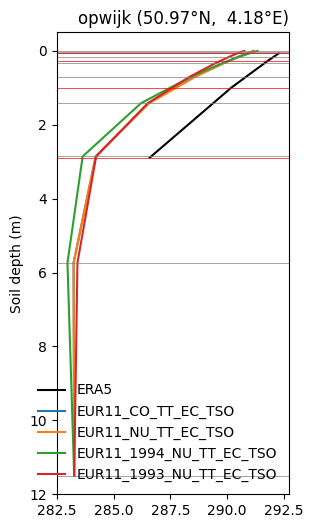

In [57]:
fig, ax = plt.subplots(figsize = (3,6))

ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
for experiment in experiments: 
    ax.plot(d_da_mod_point[experiment].values, d_da_mod_point[experiment]['soil_depth'].values,  label=experiment)

ax.invert_yaxis()
ax.set_title(' ', loc='center')
ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
#ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
ax.set_ylabel('Soil depth (m)')
ax.set_ylim([12,-0.5])

ax.legend(frameon=False, loc='lower right')


for soil_depth in da_mod_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="gray", linewidth = 0.5, label='CCLM soil levels')
    
for soil_depth in da_obs_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="red", linewidth = 0.5, linestyle='-')



### plot bias map for lowest soil layer ERA5 (2m89), and corresponding CCLM layer at 2m86

In [5]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [35,70], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [49,52], 
                    'lon_bounds': [2,7]}}

In [21]:
region='europe'

gridfile = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc'


da_obs_sel = ds_obs['tsl'].sel(soil_depth=2.89).sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
da_obs_sel.attrs['long_name'] =  'Soil temperature level 4 (2m89)'


for experiment in experiments: 
    ds_mod = d_ds_mod[experiment]
    ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "bil")
    ds_mod = ds_mod.sortby('lat')

    da_mod_sel = ds_mod['tsl'].sel(soil_depth=2.86).sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))


    calc_and_plot_timmean_bias(region, bounds, da_mod_sel, da_obs_sel, experiment, ref_dataset)

KeyError: "No variable named 'tsl'. Variables on the dataset include ['stl4', 'lon', 'lat']"

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

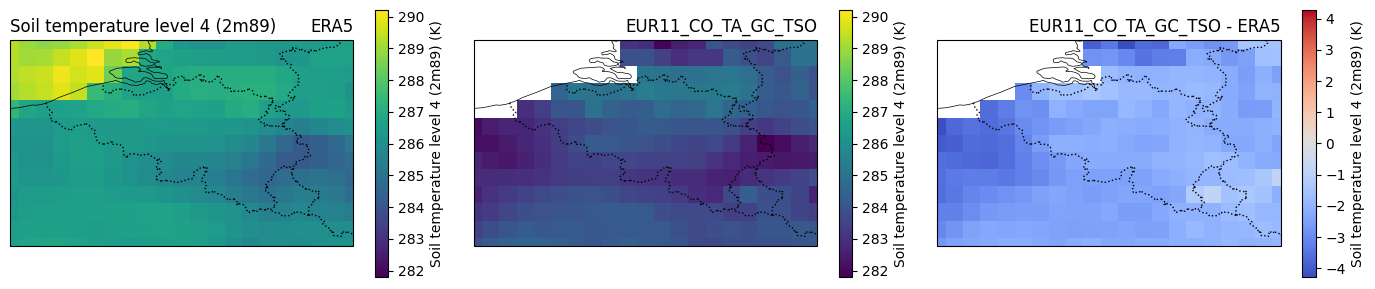

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

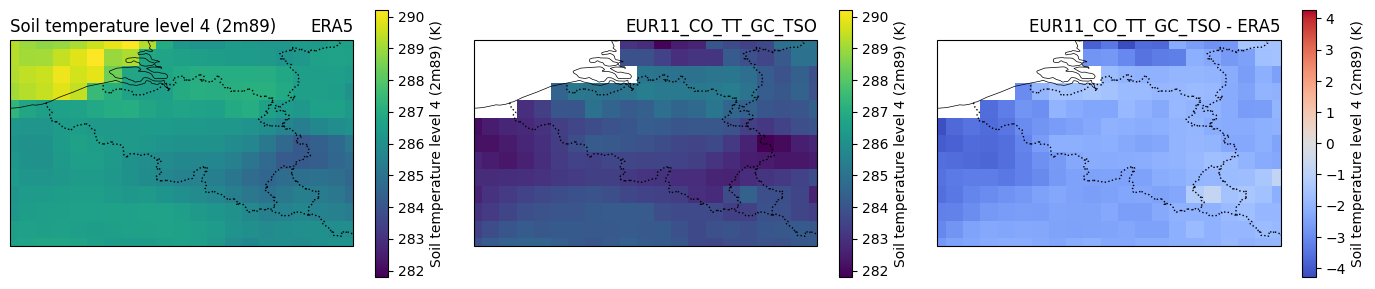

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

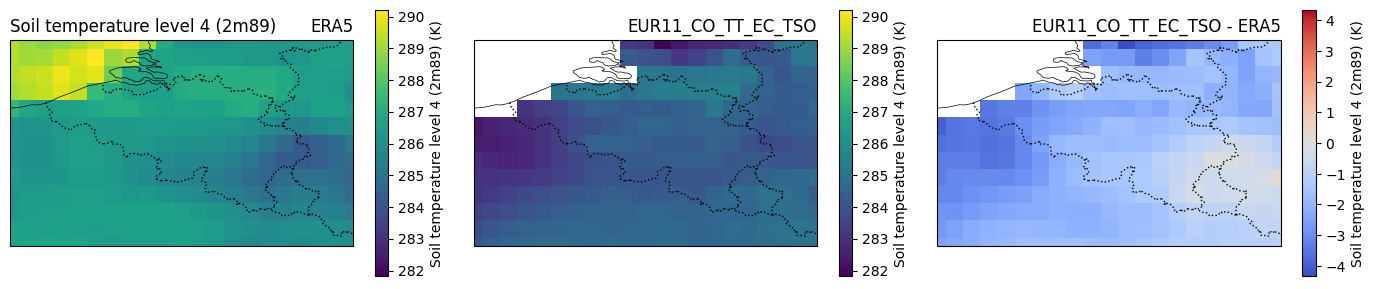

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

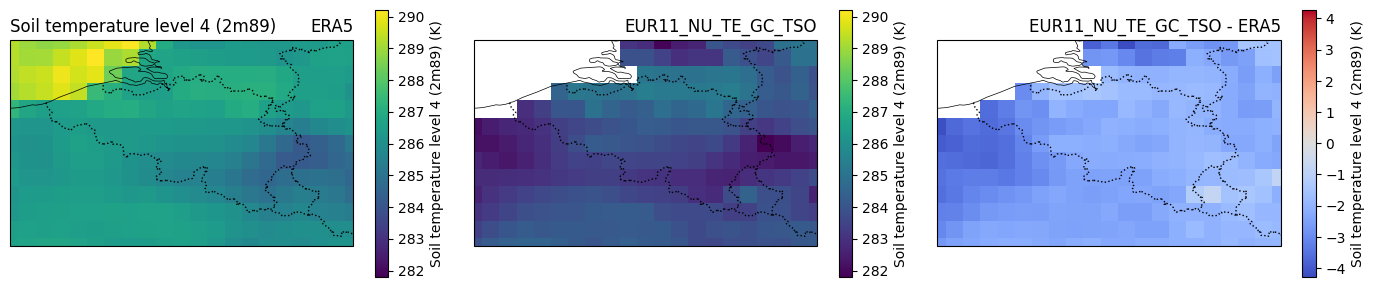

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

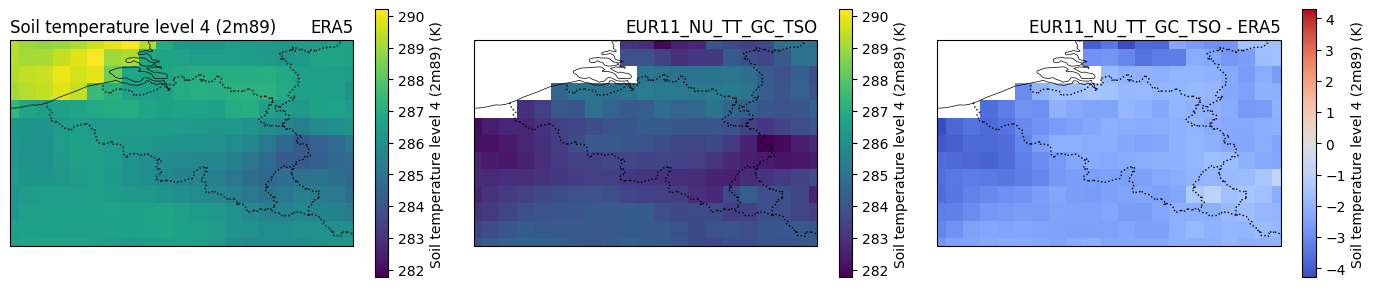

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

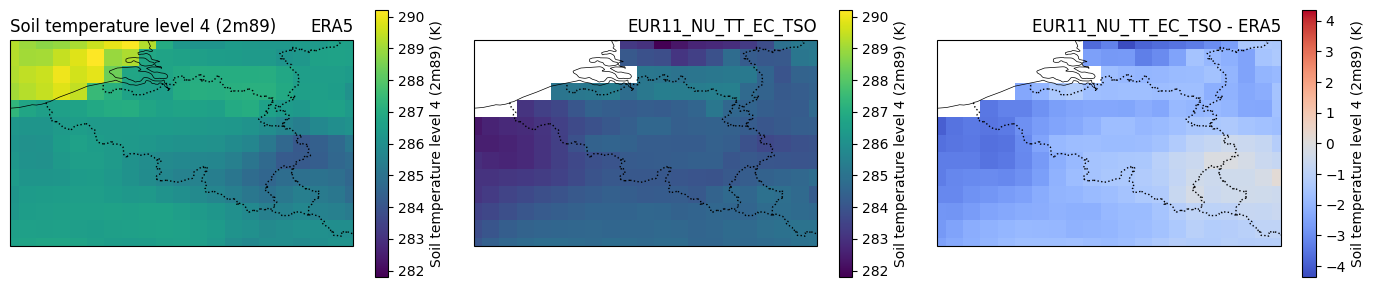

In [ ]:
region='belgium'

gridfile = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc'


da_obs_sel = ds_obs['tsl'].sel(soil_depth=2.89).sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
da_obs_sel.attrs['long_name'] =  'Soil temperature level 4 (2m89)'


for experiment in experiments: 
    ds_mod = d_ds_mod[experiment]
    ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "bil")
    ds_mod = ds_mod.sortby('lat')

    da_mod_sel = ds_mod['tsl'].sel(soil_depth=2.86).sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))


    calc_and_plot_timmean_bias(region, bounds, da_mod_sel, da_obs_sel, experiment, ref_dataset)

## Comparison with CRU data from EXTPAR

In [8]:

def calc_and_plot_timmean_bias(region: str, bounds:dict, da_mod, da_obs, experiment, ref_dataset): 

    lat_bounds = bounds[region]['lat_bounds']
    lon_bounds = bounds[region]['lon_bounds']
    if 'time' in da_mod.coords:
        da_mod = da_mod.mean('time', keep_attrs=True)
    bias = da_mod - da_obs


    fig, axes = plt.subplots(1, 3, figsize=(14, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    # find plotting min and max
    vmin = float(min(da_mod.min().values, da_obs.min().values))
    vmax = float(max(da_mod.max().values, da_obs.max().values))

    bias_bound = float(max(abs(bias.min().values), abs(bias.max().values)))


    cbar_label = f"{da_obs.attrs['long_name']} ({da_obs.attrs['units']})"
    cbar_kwargs = {'label': cbar_label}


    # Define a function to add borders, coastlines to the axes
    #def add_features(ax):
    #    ax.add_feature(cfeature.BORDERS, linestyle=':')
    #    ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = 'k')

    # obs
    ax = axes[0]
    da_obs.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
    ax.set_title(da_obs.attrs['long_name'], loc='left')
    ax.set_title('')
    ax.set_title(ref_dataset, loc='right')
    #add_features(ax)

    # mod
    ax = axes[1]
    da_mod.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
    ax.set_title('')
    ax.set_title(experiment, loc='right')
    #add_features(ax)

    # bias
    ax = axes[2]
    bias.plot(ax=ax, cmap = 'coolwarm', vmax = bias_bound, vmin = - bias_bound, cbar_kwargs=cbar_kwargs)
    ax.set_title('')
    ax.set_title(f"{experiment} - {ref_dataset}", loc='right')
    #add_features(ax)

    fig.tight_layout()
    plt.show()

    return fig
    #fig.savefig(f"./plots/{region}_{experiment}_{ref_dataset}_timmean_bias.png")


In [9]:
# Loading ECOCLIMAP data
ec_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/wouterl/exp_fiens_eval_setup_JJA1995_transient_aerosol_ECOCLIMAP/ext/'
ec_file = ec_dir + 'extpar_1995.nc'
ec_extp = xr.open_mfdataset(ec_file, combine="by_coords", chunks="auto")
da_obs_sel = ec_extp["T_CL"]

experiments = ["EUR11_NU_TT_EC_TSO"]

da_obs_sel.attrs['long_name'] =  'CRU'

region = "europe"

for experiment in experiments: 
    ds_mod = d_ds_mod[experiment]
    #ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "bil")
    #ds_mod = ds_mod.sortby('lat')

    da_mod_sel = ds_mod['tsl'].sel(soil_depth=2.86).sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))


    calc_and_plot_timmean_bias(region, bounds, da_mod_sel, da_obs_sel, experiment, 'CRU')

NameError: name 'd_ds_mod' is not defined

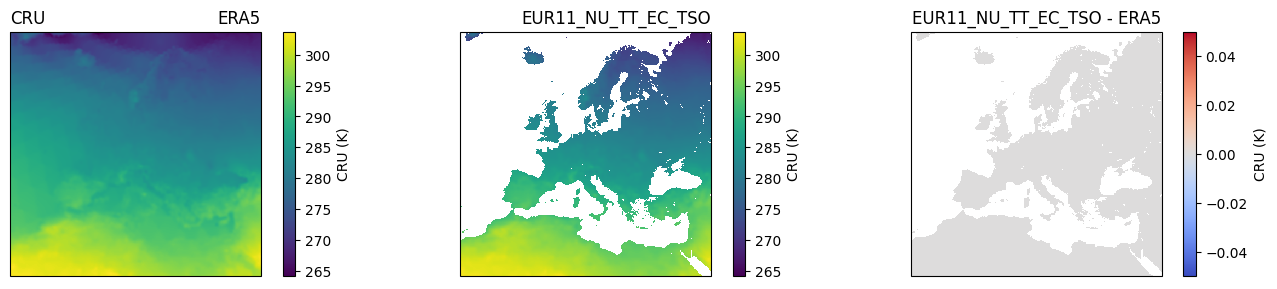

In [ ]:


for experiment in experiments: 
    ds_mod = d_ds_mod[experiment]
    #ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "bil")
    #ds_mod = ds_mod.sortby('lat')

    da_mod_sel = ds_mod['tsl'][0,-1,:,:]


    bias = da_mod_sel - da_obs_sel
    da_mod = da_mod_sel
    da_obs = da_obs_sel

    fig, axes = plt.subplots(1, 3, figsize=(14, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    # find plotting min and max
    vmin = float(min(da_mod.min().values, da_obs.min().values))
    vmax = float(max(da_mod.max().values, da_obs.max().values))

    bias_bound = float(max(abs(bias.min().values), abs(bias.max().values)))


    cbar_label = f"{da_obs.attrs['long_name']} ({da_obs.attrs['units']})"
    cbar_kwargs = {'label': cbar_label}


    # Define a function to add borders, coastlines to the axes
    #def add_features(ax):
    #    ax.add_feature(cfeature.BORDERS, linestyle=':')
    #    ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = 'k')

    # obs
    ax = axes[0]
    da_obs.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
    ax.set_title(da_obs.attrs['long_name'], loc='left')
    ax.set_title('')
    ax.set_title(ref_dataset, loc='right')
    #add_features(ax)

    # mod
    ax = axes[1]
    da_mod.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
    ax.set_title('')
    ax.set_title(experiment, loc='right')
    #add_features(ax)

    # bias
    ax = axes[2]
    bias.plot(ax=ax, cmap = 'coolwarm', vmax = bias_bound, vmin = - bias_bound, cbar_kwargs=cbar_kwargs)
    ax.set_title('')
    ax.set_title(f"{experiment} - {ref_dataset}", loc='right')
    #add_features(ax)

    fig.tight_layout()
    plt.show()

### CRU vs ERA5

In [ ]:
# Loading ECOCLIMAP data
ec_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/wouterl/exp_fiens_eval_setup_JJA1995_transient_aerosol_ECOCLIMAP/ext/'
ec_file = ec_dir + 'extpar_1995.nc'
ec_extp = xr.open_mfdataset(ec_file, combine="by_coords", chunks="auto")
da_mod_sel = ec_extp["T_CL"]
gridfile = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc'
ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "bil")
ds_mod = ds_mod.sortby('lat')

da_mod_sel = ds_mod['tsl'].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse)).mean('time')[-1,:,:]



NameError: name 'ds_mod' is not defined

In [19]:
    # 1. manually load ERA5

    ds = load_xarray_from_data_sources(obs_files)

    # rename dimensions if not yet renamed
    if "lon" not in ds.coords:
        ds = ds.rename({"longitude": "lon"})
    if "lat" not in ds.coords:
        ds = ds.rename({"latitude": "lat"})

    # make sure lat and lon are sorted ascending
    ds = ds.sortby('lat').sortby('lon')

    # bugfix ERA5 (found in clh): replace valid_time by time
    if "time" not in ds: 
        ds = ds.rename({'valid_time':'time'})

    ds = ds.resample(time='1D').mean()  


    # hardcoded from https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings 

    era5_soillayers = {'soil_depth': [0.07,0.28,1,2.89], 'thickness': [0.07,0.21,0.72,1.89], 
    'layer': ['0 - 7 cm','7 - 28 cm', '28 - 100 cm ', '100 - 289 cm']} #m 

    da_obs= xr.concat([ds['stl1'], ds['stl2'], ds['stl3'], ds['stl4']], dim='soil_depth')

    da_obs['soil_depth'] = era5_soillayers['soil_depth']

    ds_obs = da_obs.to_dataset(name=variable)


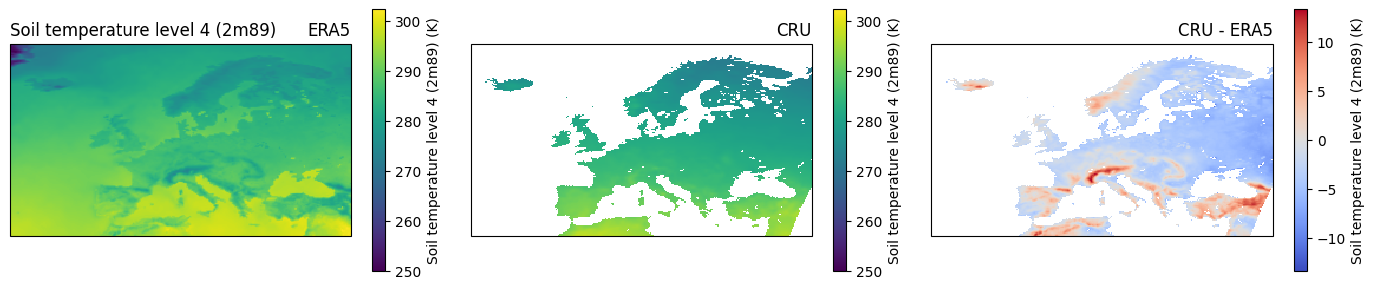

In [20]:
da_obs_sel = ds_obs['tsl'].sel(soil_depth=2.89).sel(time=ds_obs['time'].dt.month.isin(months_to_analyse)).mean('time')
da_obs_sel.attrs['long_name'] =  'Soil temperature level 4 (2m89)'

bias = da_mod_sel - da_obs_sel
da_mod = da_mod_sel
da_obs = da_obs_sel

fig, axes = plt.subplots(1, 3, figsize=(14, 3), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# find plotting min and max
vmin = float(min(da_mod.min().values, da_obs.min().values))
vmax = float(max(da_mod.max().values, da_obs.max().values))

bias_bound = float(max(abs(bias.min().values), abs(bias.max().values)))


cbar_label = f"{da_obs.attrs['long_name']} ({da_obs.attrs['units']})"
cbar_kwargs = {'label': cbar_label}


# Define a function to add borders, coastlines to the axes
#def add_features(ax):
#    ax.add_feature(cfeature.BORDERS, linestyle=':')
#    ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = 'k')

# obs
ax = axes[0]
da_obs.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
ax.set_title(da_obs.attrs['long_name'], loc='left')
ax.set_title('')
ax.set_title(ref_dataset, loc='right')
#add_features(ax)

# mod
ax = axes[1]
da_mod.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
ax.set_title('')
ax.set_title("CRU", loc='right')
#add_features(ax)

# bias
ax = axes[2]
bias.plot(ax=ax, cmap = 'coolwarm', vmax = bias_bound, vmin = - bias_bound, cbar_kwargs=cbar_kwargs)
ax.set_title('')
ax.set_title(f"CRU - {ref_dataset}", loc='right')
#add_features(ax)

fig.tight_layout()
plt.show()

## ERA5 for different years

In [55]:
years = range(1990,2020)
obs_files = [f'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/monthly/era5-monthly-europe-soil_temperature_level_4-{year}.nc' for year in years]

obs_files

['/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/monthly/era5-monthly-europe-soil_temperature_level_4-1990.nc',
 '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/monthly/era5-monthly-europe-soil_temperature_level_4-1991.nc',
 '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/monthly/era5-monthly-europe-soil_temperature_level_4-1992.nc',
 '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/monthly/era5-monthly-europe-soil_temperature_level_4-1993.nc',
 '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/monthly/era5-monthly-europe-soil_temperature_level_4-1994.nc',
 '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/monthly/era5-monthly-europe-soi

In [56]:
    # 1. manually load ERA5

    ds = load_xarray_from_data_sources(obs_files)

    # rename dimensions if not yet renamed
    if "lon" not in ds.coords:
        ds = ds.rename({"longitude": "lon"})
    if "lat" not in ds.coords:
        ds = ds.rename({"latitude": "lat"})

    # make sure lat and lon are sorted ascending
    ds = ds.sortby('lat').sortby('lon')

    # bugfix ERA5 (found in clh): replace valid_time by time
    if "time" not in ds: 
        ds = ds.rename({'valid_time':'time'})

    #ds = ds.mean('time')  


    # hardcoded from https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings 


    ds_obs = ds


FileNotFoundError: [Errno 2] No such file or directory: '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/soil_temperature_level_4/monthly/era5-monthly-europe-soil_temperature_level_4-1998.nc'

In [53]:
da_obs_sel = ds_obs['stl4'].mean('time')
da_obs_sel.attrs['long_name'] =  'Soil temperature level 4 (2m89)'

da_mod = da_mod_sel
da_obs = da_obs_sel
bias = da_mod_sel - da_obs_sel

fig, axes = plt.subplots(1, 3, figsize=(14, 3), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# find plotting min and max
vmin = float(min(da_mod.min().values, da_obs.min().values))
vmax = float(max(da_mod.max().values, da_obs.max().values))

bias_bound = float(max(abs(bias.min().values), abs(bias.max().values)))


cbar_label = f"{da_obs.attrs['long_name']} ({years}) ({da_obs.attrs['units']})"
cbar_kwargs = {'label': cbar_label}


# Define a function to add borders, coastlines to the axes
#def add_features(ax):
#    ax.add_feature(cfeature.BORDERS, linestyle=':')
#    ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = 'k')

# obs
ax = axes[0]
da_obs.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
ax.set_title(da_obs.attrs['long_name'], loc='left')
ax.set_title('')
ax.set_title(ref_dataset, loc='right')
#add_features(ax)

# mod
ax = axes[1]
da_mod.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
ax.set_title('')
ax.set_title("CRU", loc='right')
#add_features(ax)

# bias
ax = axes[2]
bias.plot(ax=ax, cmap = 'coolwarm', vmax = bias_bound, vmin = - bias_bound, cbar_kwargs=cbar_kwargs)
ax.set_title('')
ax.set_title(f"CRU - {ref_dataset}", loc='right')
#add_features(ax)

fig.tight_layout()
plt.show()

NameError: name 'da_mod_sel' is not defined

<Axes: title={'left': 'Soil temperature level 4', 'center': ' '}, xlabel='time', ylabel='Soil temperature level 4 [K]'>

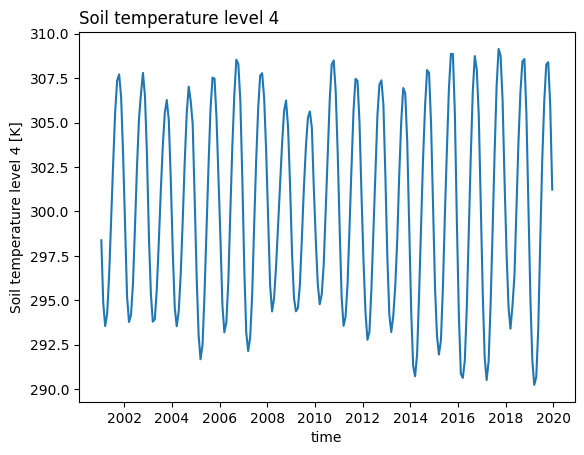

In [57]:


from valenspy.preprocessing_tasks.select import select_point
from valenspy.diagnostic_visualizations import plot_time_series

#    ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = 'k')
da_obs_sel = ds_obs['stl4']
da_obs_point = select_point(da_obs_sel, (50.97, 4.18), rotated_pole=False)

plot_time_series(da_obs_point)
